# Milestone Project: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

Links: https://arxiv.org/abs/1710.06071

The model architechture that they use to achieve their best results is https://arxiv.org/abs/1612.05251

## GPU access

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5b21a1cf-4ae6-0575-0ad4-c37b7049d0ca)


## Get data

In [ ]:
# replicate PubMed 200k RCT paper
# download their datasets
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/ # numbers replaced with @ sign

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiment using 20k dataset with numbers replaced by @ sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data


In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with on string per line from the target filename
  """
  with open(filename,'r') as f:
    return f.readlines()


In [ ]:
# Read in the training lines
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Reformat the data as below
```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines': 11,
   ...]
```   

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of directionaries of abstract line data

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text ofthe sentences,
  how many sentencces are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = []

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'): # return true if start with ###
      abstract_id = line
      abstract_lines = "" # reset the abstarct string if the line is an ID line

    elif line.isspace(): # check if new line \n
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data={} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appearr in the abstract
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract?
        abstract_samples.append(line_data)

    else: # if the above conditions are'nt fullfiled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples


In [ ]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # dev is another name for validation
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

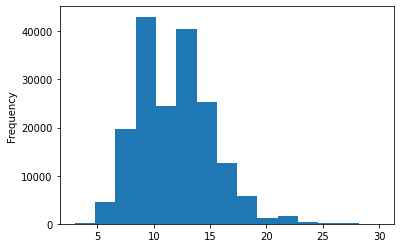

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist(bins=15)

### Get list of sentences

In [ ]:
# Convert abstract text line into list
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences) , len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# view the first 10 lines
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # tensorflow is incompatible with sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1)) # fit and transform
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1)) # transform only because the previous fitted data has the same structure
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Integer encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline (TF-IDF Multinomial Naive Bayes classifier)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB()),
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded) # Error if pass train_labels_one_hot unless sklearn update MultinomialNB to be able handle one hot labels

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds, val_labels_encoded

(array([4, 1, 3, ..., 4, 4, 1]), array([0, 0, 3, ..., 4, 1, 1]))

### Download helper function script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-23 12:16:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-23 12:16:56 (57.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Prepare text into numeric format (for deep sequence models)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences] # .split() split sentences into individual word (token)
np.mean(sent_lens)

26.338269273494777

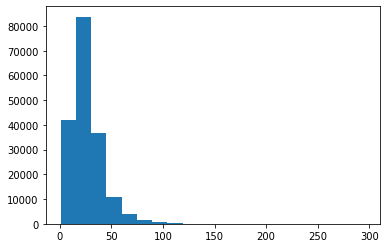

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = round(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

maps our text from word(token) to number

In [ ]:
# How many words are in our vocab? (taken from reprecate paper)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences) # fit

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
secretory iga antibody responses in fecal samples and iga responses in secretions from circulating intestine-derived antibody secreting cells were assessed as primary measures of vaccine immunogenicity .

Length of text: 27

Vectorized text: [[10170  4778  1029   442     5  2495   513     3  4778   442     5  7787
     27  1837 37785  1029 24680   586     9   113    25    56   213     4
    497  1929     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [ ]:
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of vocabulary
                               output_dim = 128, # multiple of 8
                               mask_zero = True, # mask 0 values
                               name = "token_embedding") 

In [ ]:
# Show example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')

vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n {vectorized_sentence}\n")

embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 secretory iga antibody responses in fecal samples and iga responses in secretions from circulating intestine-derived antibody secreting cells were assessed as primary measures of vaccine immunogenicity .

Sentence after vectorization:
 [[10170  4778  1029   442     5  2495   513     3  4778   442     5  7787
     27  1837 37785  1029 24680   586     9   113    25    56   213     4
    497  1929     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.0331003   0.0461641  -0.0321955  ... -0.01051491  0.02930422
    0.02445188]
  [-0.02874853 -0.02433337 -0.0118799  ...  0.01059593  0.00726981
   -0.02629598]
  [ 0.03223426 -0.0054484   0.02229216 ... -0.01025992  0.00730447
   -0.02310612]
  ...
  [ 0.04339557  0.03015938  0.04874922 ... -0.0287563   0.04593765
   -0.03671094]
  [ 0.04339557  0.030159

## Creating datasets (making sure our data loads as fast as possible)

Setup our data to run as fast fas possible with TensorFlow tf.data API

In [ ]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset # TensorSliceDataset tuple

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take the TensorSlicesDataset and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # not shuffle because order matters
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings) # kernel_size=5 look at 5 words at a time
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1*len(train_dataset)), # look at only 10 percent of training dataset 
                              validation_data = val_dataset,
                              validation_steps = int(0.1*len(val_dataset)) # only validate on 10% of batches
                              )

Epoch 1/3
562/562 [==============================] - 9s 14ms/step - loss: 0.9302 - accuracy: 0.6253 - val_loss: 0.6941 - val_accuracy: 0.7324
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6595 - accuracy: 0.7568 - val_loss: 0.6293 - val_accuracy: 0.7670
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6173 - accuracy: 0.7757 - val_loss: 0.5954 - val_accuracy: 0.7836


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5968 - accuracy: 0.7868


[0.5967777967453003, 0.7868396639823914]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.1478181e-01, 1.8638927e-01, 6.5946557e-02, 3.0631641e-01,
         2.6565952e-02],
        [4.5141006e-01, 2.5718510e-01, 9.4926497e-03, 2.7397203e-01,
         7.9402225e-03],
        [1.3601744e-01, 4.4029602e-03, 1.2646209e-03, 8.5826963e-01,
         4.5396413e-05],
        ...,
        [3.5590315e-06, 7.7916984e-04, 7.9922046e-04, 3.3729091e-06,
         9.9841464e-01],
        [4.9266819e-02, 4.4614238e-01, 9.5163681e-02, 5.8469232e-02,
         3.5095793e-01],
        [2.0449223e-01, 6.6857475e-01, 6.7325383e-02, 3.2430399e-02,
         2.7177278e-02]], dtype=float32), (30212, 5))

In [ ]:
model_1_pred = tf.argmax(model_1_pred_probs, axis=1)
model_1_pred[:10], val_labels_encoded[:10]

(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1])>,
 array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1]))

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_pred)
model_1_results, baseline_results

({'accuracy': 78.68396663577386,
  'f1': 0.7844359978083706,
  'precision': 0.7836460442017253,
  'recall': 0.7868396663577386},
 {'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869})

## Model 2: TensorFlow Hub Pretrained Embedding Feature Extractor

Universal sentence encoder

Link: https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False, name = 'universal_sentence_encoder') # no fine-tuning

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence: {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:20]}')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random sentence: future studies should investigate lengthening the intervention to enhance effectiveness and increasing recruitment to improve statistical power .
Sentence after embedding:
[-0.00721563 -0.05690084  0.02181671  0.00527354 -0.08283545 -0.04685256
  0.05869931 -0.04205904  0.0221514   0.01549699  0.01807919  0.05568088
  0.06570862  0.0300434   0.07664033  0.009615   -0.06163158 -0.06352076
 -0.02422697 -0.07139802]
Length of sentence embedding: 512


In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=[], dtype=tf.string) # input need to be a list
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_use_feature_extractor')

# compile
model_2.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data = val_dataset,
                              validation_steps = int(0.1 * len(val_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 16s 22ms/step - loss: 0.9154 - accuracy: 0.6504 - val_loss: 0.7916 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7649 - accuracy: 0.7042 - val_loss: 0.7464 - val_accuracy: 0.7108
Epoch 3/3
562/562 [==============================] - 12s 22ms/step - loss: 0.7448 - accuracy: 0.7172 - val_loss: 0.7287 - val_accuracy: 0.7194


In [ ]:
model_2.save('model_2.h5')

In [ ]:
load_model_2 = tf.keras.models.load_model('model_2.h5', 
                                          custom_objects = {'KerasLayer': hub.KerasLayer})

In [ ]:
# Evaluate
model_2.evaluate(val_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.7336 - accuracy: 0.7178


[0.7335808277130127, 0.7177942395210266]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[4.3033144e-01, 3.5558927e-01, 2.5006642e-03, 2.0311531e-01,
        8.4632961e-03],
       [3.4810430e-01, 4.9177337e-01, 4.4342680e-03, 1.5212889e-01,
        3.5591479e-03],
       [2.3405285e-01, 1.5135773e-01, 1.8411823e-02, 5.5074030e-01,
        4.5437321e-02],
       ...,
       [1.7034358e-03, 5.9766117e-03, 5.1915232e-02, 7.7055459e-04,
        9.3963414e-01],
       [4.0304828e-03, 4.8085734e-02, 1.8040195e-01, 1.2513832e-03,
        7.6623040e-01],
       [1.2921175e-01, 2.9167718e-01, 5.1312995e-01, 5.2022277e-03,
        6.0778867e-02]], dtype=float32)

In [ ]:
model_2_pred = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred, val_labels_encoded

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>,
 array([0, 0, 3, ..., 4, 1, 1]))

In [ ]:
# Calculate results from TF Hub pretrained embedding results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_pred)
model_2_results, baseline_results

({'accuracy': 71.77942539388323,
  'f1': 0.7149081202352001,
  'precision': 0.7183057516330702,
  'recall': 0.7177942539388322},
 {'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869})

## Model 3: Conv1D with character embeddings

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
",".join(list(train_sentences[0]))

't,o, ,i,n,v,e,s,t,i,g,a,t,e, ,t,h,e, ,e,f,f,i,c,a,c,y, ,o,f, ,@, ,w,e,e,k,s, ,o,f, ,d,a,i,l,y, ,l,o,w,-,d,o,s,e, ,o,r,a,l, ,p,r,e,d,n,i,s,o,l,o,n,e, ,i,n, ,i,m,p,r,o,v,i,n,g, ,p,a,i,n, ,,, ,m,o,b,i,l,i,t,y, ,,, ,a,n,d, ,s,y,s,t,e,m,i,c, ,l,o,w,-,g,r,a,d,e, ,i,n,f,l,a,m,m,a,t,i,o,n, ,i,n, ,t,h,e, ,s,h,o,r,t, ,t,e,r,m, ,a,n,d, ,w,h,e,t,h,e,r, ,t,h,e, ,e,f,f,e,c,t, ,w,o,u,l,d, ,b,e, ,s,u,s,t,a,i,n,e,d, ,a,t, ,@, ,w,e,e,k,s, ,i,n, ,o,l,d,e,r, ,a,d,u,l,t,s, ,w,i,t,h, ,m,o,d,e,r,a,t,e, ,t,o, ,s,e,v,e,r,e, ,k,n,e,e, ,o,s,t,e,o,a,r,t,h,r,i,t,i,s, ,(, ,o,a, ,), ,.'

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non_character-level sequence into characters
split_chars(random_train_sentence)

'f u t u r e   s t u d i e s   s h o u l d   i n v e s t i g a t e   l e n g t h e n i n g   t h e   i n t e r v e n t i o n   t o   e n h a n c e   e f f e c t i v e n e s s   a n d   i n c r e a s i n g   r e c r u i t m e n t   t o   i m p r o v e   s t a t i s t i c a l   p o w e r   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

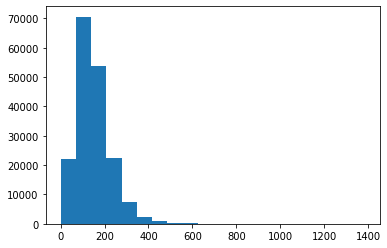

In [ ]:
# Check the distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20)

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet # cover every character in the keyboard

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
num_char_tokens = len(alphabet) + 2 # add 2 for space and oov token (oov = out of vocab or unknown)
char_vectorizer = TextVectorization(max_tokens=num_char_tokens,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = 'lower_and_strip_punctuation', # default
                                    name='char_vectorizer'
                                    )

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars) # fit

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
 t h e s e   r e s u l t s   s u g g e s t   t h a t   c a r e f u l l y   t i t r a t e d   i m m e d i a t e - r e l e a s e   d o s e s   o f   o p i o i d   d r u g s   m a y   n o t   c a u s e   e x t e n s i v e   m e m o r y   i m p a i r m e n t   a s   p r e v i o u s l y   r e p o r t e d   ,   a n d   i n   f a c t   ,   m a y   i m p r o v e   m e m o r y   i n   c e r t a i n   c i r c u m s t a n c e s   .

Length of random_train_chars: 181

Vectorized chars:
 [[ 3 13  2  9  2  8  2  9 16 12  3  9  9 16 18 18  2  9  3  3 13  5  3 11
   5  8  2 17 16 12 12 19  3  4  3  8  5  3  2 10  4 15 15  2 10  4  5  3
   2  8  2 12  2  5  9  2 10  7  9  2  9  7 17  7 14  4  7  4 10 10  8 16
  18  9 15  5 19  6  7  3 11  5 16  9  2  2 24  3  2  6  9  4 21  2 15  2
  15  7  8 19  4 15 14  5  4  8 15  2  6  3  5  9 14  8  2 21  4  7 16  9
  12 19  8  2 14  7  8  3  2 10  5  6 10  4  6 17  5 11  3 15  5 19  4 15
  14  8  7 21  2 15  2 15  7  8 19  4  6 11  2  8  3  5  4  

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # size of the vocab
                              output_dim=25, # this is the size of the character embedding in the paper
                              mask_zero=False,
                              name='char_embed')

In [ ]:
# Test our character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n {char_embed_example}')
print(f'\nCharacter embedding shape: {char_embed_example.shape}')

Charified text:
 t h e s e   r e s u l t s   s u g g e s t   t h a t   c a r e f u l l y   t i t r a t e d   i m m e d i a t e - r e l e a s e   d o s e s   o f   o p i o i d   d r u g s   m a y   n o t   c a u s e   e x t e n s i v e   m e m o r y   i m p a i r m e n t   a s   p r e v i o u s l y   r e p o r t e d   ,   a n d   i n   f a c t   ,   m a y   i m p r o v e   m e m o r y   i n   c e r t a i n   c i r c u m s t a n c e s   .

Embedded chars (after vectorization and embedding):
 [[[-0.0328851  -0.00410782 -0.01691518 ...  0.00752949 -0.02169924
    0.0329435 ]
  [-0.00809477 -0.00023754  0.01393249 ... -0.00805058 -0.02374725
    0.01556978]
  [-0.00059354 -0.00832142 -0.00221352 ...  0.04471309 -0.00820262
    0.01212605]
  ...
  [-0.00127659 -0.02720377  0.03795011 ... -0.04015849  0.0038682
   -0.04261885]
  [-0.00127659 -0.02720377  0.03795011 ... -0.04015849  0.0038682
   -0.04261885]
  [-0.00127659 -0.02720377  0.03795011 ... -0.04015849  0.0038682
   -0.04261885]]]

C

In [ ]:
# Build the model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
tokens = char_vectorizer(inputs)
embed = char_embed(tokens)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(embed)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs,outputs, name = 'model_3_conv1D_char_embed')

model_3.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 5)   

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)),
                              epochs=5
                              )

Epoch 1/5
562/562 [==============================] - 7s 10ms/step - loss: 1.2526 - accuracy: 0.4958 - val_loss: 1.0445 - val_accuracy: 0.5858
Epoch 2/5
562/562 [==============================] - 6s 10ms/step - loss: 1.0152 - accuracy: 0.5925 - val_loss: 0.9480 - val_accuracy: 0.6233
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.9425 - accuracy: 0.6291 - val_loss: 0.8781 - val_accuracy: 0.6586
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 0.8872 - accuracy: 0.6559 - val_loss: 0.8476 - val_accuracy: 0.6715
Epoch 5/5
562/562 [==============================] - 5s 10ms/step - loss: 0.8732 - accuracy: 0.6582 - val_loss: 0.8301 - val_accuracy: 0.6745


In [ ]:
model_3.save('model_3.h5')

NotImplementedError: ignored

In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8526 - accuracy: 0.6690


[0.8526466488838196, 0.6690056920051575]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.17153898, 0.473851  , 0.11852886, 0.18008538, 0.05599574],
       [0.22149439, 0.4025937 , 0.00897541, 0.35372517, 0.01321137],
       [0.10490678, 0.17815115, 0.2127128 , 0.45930722, 0.04492201],
       ...,
       [0.02798034, 0.05889513, 0.11999969, 0.02013185, 0.77299297],
       [0.03250439, 0.13552925, 0.48191097, 0.02294328, 0.32711208],
       [0.27815506, 0.5488504 , 0.14120759, 0.02659059, 0.00519635]],
      dtype=float32)

In [ ]:
model_3_pred = tf.argmax(model_3_pred_probs, axis=1)
model_3_pred, baseline_preds

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>,
 array([4, 1, 3, ..., 4, 4, 1]))

In [ ]:
# calculate predictions result
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_pred)
model_3_results, baseline_results

({'accuracy': 66.90056931020787,
  'f1': 0.6632206808089932,
  'precision': 0.6788276524405124,
  'recall': 0.6690056931020787},
 {'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869})

## Model 4: Combining pretrained token embedding + characters embedding (hybrid embedding layer)

1. Create a token-level embedding model (similiar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
from tensorflow.keras import layers
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input') # list shape input for USE
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Set up character-level inputs/model
char_inputs = layers.Input(shape=[], dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, name = 'char_lstm'), name = 'char_bidirectional')(char_embeddings) # bi-LSTM, the hidden unit gets double when using bidirectional because it goes from left to right and right to left
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input], # order (tokens, chars)
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embedding')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

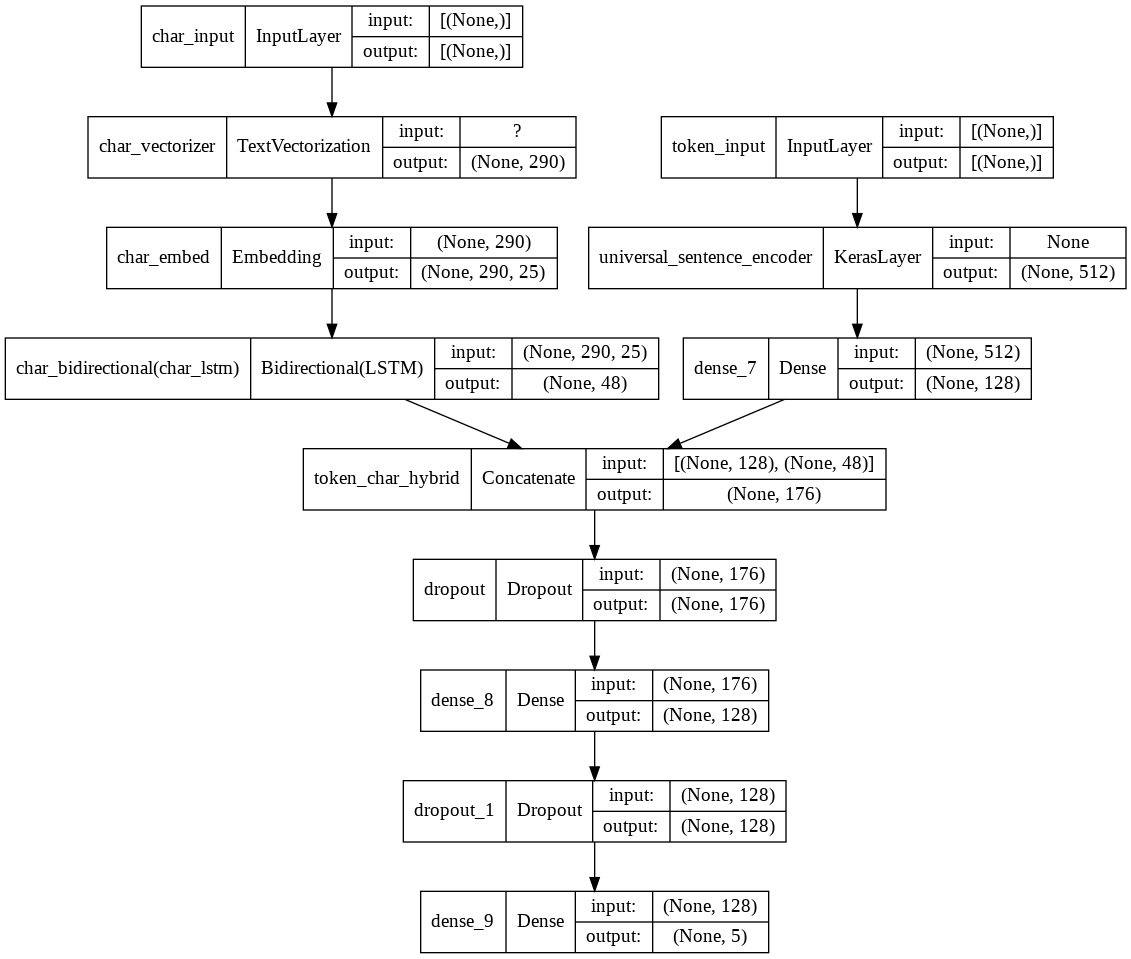

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

Extra: Checkout airbnb multimodal

https://medium.com/airbnb-engineering/widetext-a-multimodal-deep-learning-framework-31ce2565880c

In [ ]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data, order (tokens, chars)
train_char_token_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_label)) # combine two datasets

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make data
val_char_token_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # Make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_label)) # combine two datasets

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Combine chars and tokens into a dataset
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars)) # Make data
test_char_token_label = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # Make labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_label)) # combine two datasets

# Prefetch and batch train data
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 119ms/step - loss: 0.9917 - accuracy: 0.6076 - val_loss: 0.7909 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 66s 117ms/step - loss: 0.8029 - accuracy: 0.6922 - val_loss: 0.7253 - val_accuracy: 0.7251
Epoch 3/3
562/562 [==============================] - 65s 117ms/step - loss: 0.7787 - accuracy: 0.7020 - val_loss: 0.6963 - val_accuracy: 0.7394


In [ ]:
model_4.save('model_4.h5')

NotImplementedError: ignored

In [ ]:
model_4.save('model_4', save_format='tf')

INFO:tensorflow:Assets written to: model_4/assets


INFO:tensorflow:Assets written to: model_4/assets


In [ ]:
load_model_4 = tf.keras.models.load_model('model_4')

In [ ]:
load_model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 220s 232ms/step - loss: 0.7012 - accuracy: 0.7318


[0.7012406587600708, 0.7317622303962708]

In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6971 - accuracy: 0.7338


[0.697062075138092, 0.7337812781333923]

In [ ]:
# Make predictions using the token-char model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.6468849e-01, 4.4180238e-01, 4.9478151e-03, 1.8121278e-01,
        7.3485537e-03],
       [3.7415266e-01, 4.1553447e-01, 3.7641900e-03, 2.0454513e-01,
        2.0035093e-03],
       [3.1686383e-01, 9.8782867e-02, 4.3371052e-02, 5.1799762e-01,
        2.2984607e-02],
       ...,
       [3.7594000e-04, 4.8819287e-03, 4.5951817e-02, 1.4144291e-04,
        9.4864887e-01],
       [7.3005538e-03, 6.2174994e-02, 1.8378896e-01, 3.7711198e-03,
        7.4296439e-01],
       [2.2395341e-01, 4.2873731e-01, 2.6849672e-01, 2.7383173e-02,
        5.1429376e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results, baseline_results

({'accuracy': 73.37812789620018,
  'f1': 0.7310867236494402,
  'precision': 0.7333095099768943,
  'recall': 0.7337812789620018},
 {'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869})

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

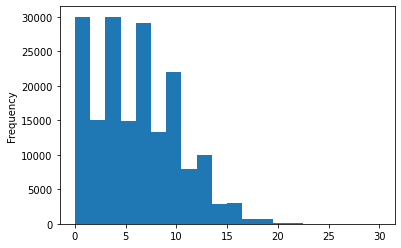

In [ ]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist(bins=20)

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our line_number column
# one hot encode so that our model doesnt think 2 is twice as large as 1 for example
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'], depth = 15) # cut at 15
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'], depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'], depth = 15)

train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

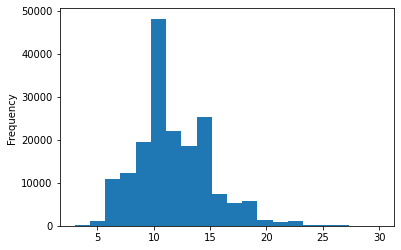

In [ ]:
train_df.total_lines.plot.hist(bins=20)

In [ ]:
# Check the coverage of a "total_lines"
np.percentile(train_df.total_lines,98)

20.0

In [ ]:
# Use Tensorflow to create one-hot encoded tensors of our total_lines feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'], depth = 20) # cut at 20
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'], depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'], depth = 20)

train_total_lines_one_hot[:14], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(14, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a char-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3 & 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outpts of 7 into a tf.keras.Model

In [ ]:
train_total_lines_one_hot[0].dtype

tf.float32

In [ ]:
# 1. Token inputs
from tensorflow.keras import layers
token_inputs = layers.Input(shape=[], dtype=tf.string, name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, name='char_lstm'), name = 'char_bidirec')(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. line_number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name = 'line_number_inputs')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs, outputs = x)

# 4. total_lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs, outputs = y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output, char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
hybrid_embeddings = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with hybrid embedding
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output, total_lines_model.output, hybrid_embeddings])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation='softmax', name = 'output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input, 
                                   total_lines_model.input, 
                                   token_model.input, 
                                   char_model.input],
                         outputs = output_layer,
                         name = 'model_5_tribrid_embedding_model')

In [ ]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

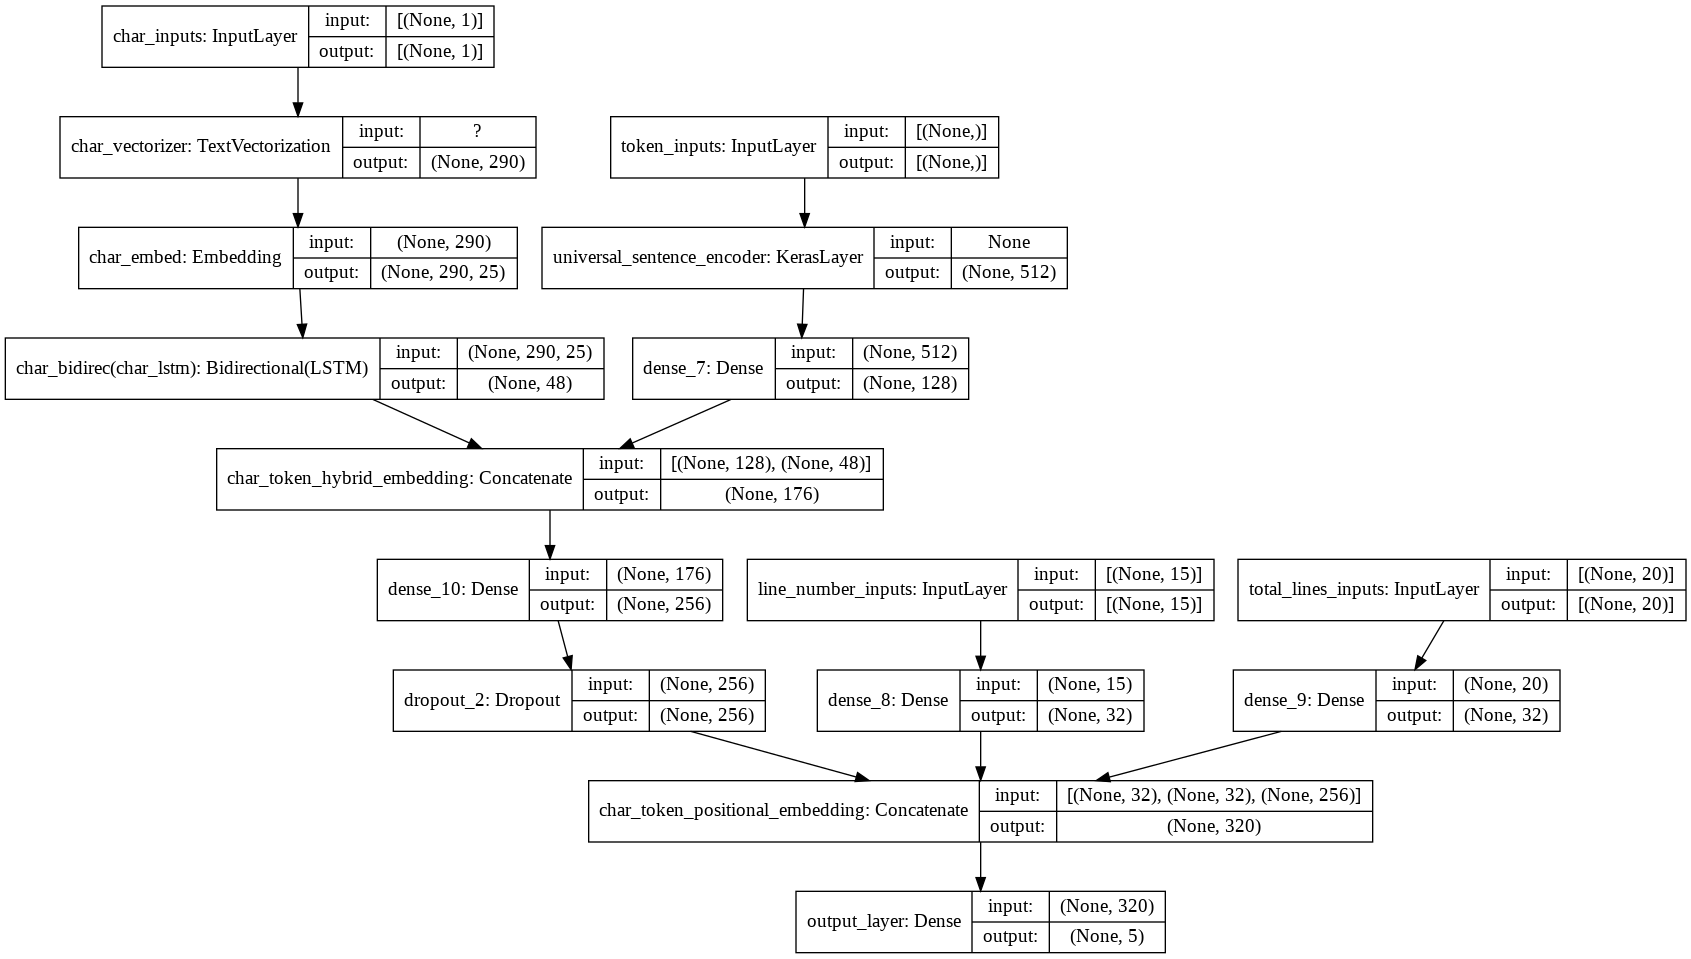

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile model_5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label_smoothing helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

What is label_smoothing?

If our model gets too confident on a signle class (high prediction probability), it may get stuck on that class and not consider otehr classes
- label_smoothing assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization

### Create tribrid embedding datasets using tf.data

In [ ]:
# Train
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

# Validation
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

# Test
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_triobrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_triobrid_labels))

# Batch & Prefetch
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_tribrid_dataset, val_tribrid_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# Fit model
history_model_5 = model_5.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1*len(train_tribrid_dataset)),
                              validation_data = val_tribrid_dataset,
                              validation_steps = int(0.1*len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 23s 35ms/step - loss: 1.0993 - accuracy: 0.7230 - val_loss: 0.9876 - val_accuracy: 0.8025
Epoch 2/3
562/562 [==============================] - 18s 33ms/step - loss: 0.9686 - accuracy: 0.8157 - val_loss: 0.9505 - val_accuracy: 0.8238
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9498 - accuracy: 0.8230 - val_loss: 0.9405 - val_accuracy: 0.8288


In [ ]:
# Evaluate the model
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.9387 - accuracy: 0.8305


[0.9387397766113281, 0.8305309414863586]

In [ ]:
# Make predictions
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_pred_probs

array([[0.47846335, 0.11709924, 0.01112977, 0.3702579 , 0.0230498 ],
       [0.50554156, 0.12538163, 0.04004886, 0.31774095, 0.01128703],
       [0.26141328, 0.10437238, 0.11549793, 0.446743  , 0.07197349],
       ...,
       [0.03189604, 0.08901214, 0.03432779, 0.02795045, 0.8168135 ],
       [0.02521843, 0.2866875 , 0.07481951, 0.02367554, 0.589599  ],
       [0.25159895, 0.5811069 , 0.08273406, 0.03902134, 0.0455388 ]],
      dtype=float32)

In [ ]:
model_5_pred = tf.argmax(model_5_pred_probs, axis=1)
model_5_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_pred)
model_5_results, model_4_results

({'accuracy': 83.05309148682642,
  'f1': 0.8297025335957734,
  'precision': 0.8296696693663159,
  'recall': 0.8305309148682642},
 {'accuracy': 73.37812789620018,
  'f1': 0.7310867236494402,
  'precision': 0.7333095099768943,
  'recall': 0.7337812789620018})

## Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results
                                  })
all_model_results = all_model_results.transpose()

# scale accuracy
all_model_results['accuracy'] = all_model_results['accuracy']/100

all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.785019,0.781653,0.785019,0.782523
model_2_pretrained_token_embedding,0.712333,0.712443,0.712333,0.709245
model_3_custom_char_embedding,0.679531,0.680626,0.679531,0.674100
model_4_hybrid_char_token_embedding,0.733781,0.733310,0.733781,0.731087
model_5_pos_char_token_embedding,0.830531,0.829670,0.830531,0.829703


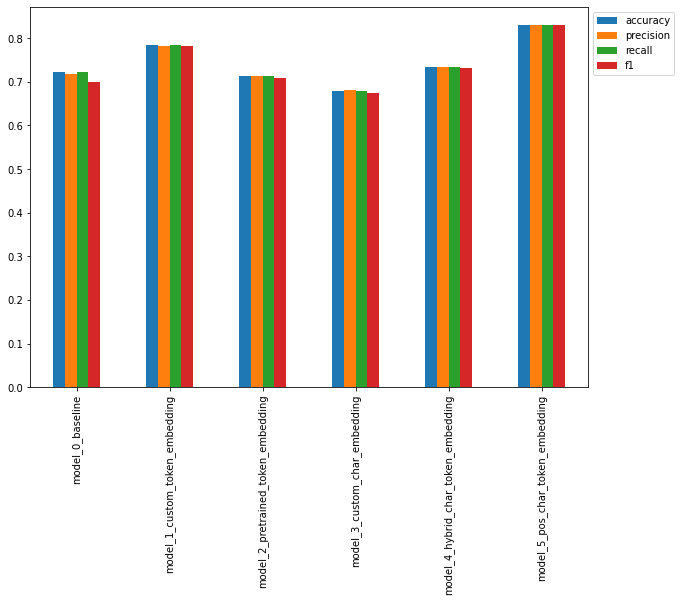

In [ ]:
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1,1));

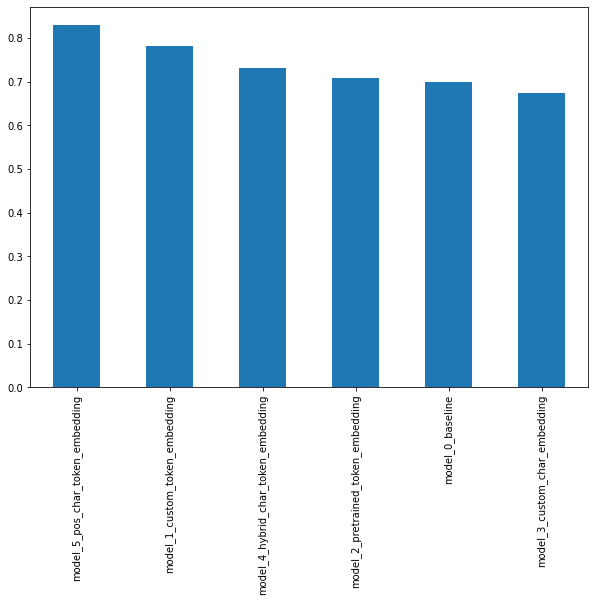

In [ ]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7));

## Save & Load model

In [ ]:
# model_5.save('/content/drive/MyDrive/personal_project/Tensorflow/skimlit_tribrid_model')

In [ ]:
loaded_model_5 = tf.keras.models.load_model('/content/drive/MyDrive/personal_project/Tensorflow/skimlit_tribrid_model')

AssertionError: ignored

In [ ]:
loaded_model_5.save('model_5.h5')

NameError: ignored

In [ ]:
loaded_pred_probs = loaded_model_5.predict(val_tribrid_dataset)
loaded_pred = tf.argmax(loaded_pred_probs,axis=1)
loaded_model_5_results = calculate_results(y_true = val_labels_encoded,
                                           y_pred = loaded_pred)
loaded_model_5_results

{'accuracy': 83.02992188534357,
 'f1': 0.8291493642982117,
 'precision': 0.8289933806478853,
 'recall': 0.8302992188534357}

In [ ]:
model_5_results

{'accuracy': 83.05309148682642,
 'f1': 0.8297025335957734,
 'precision': 0.8296696693663159,
 'recall': 0.8305309148682642}

## Next steps
1. Turn the test data samples into a tf.data Dataset (fast loading) and them evaluate (make predictions) the best performing model on the test samples
2. Find the most wrong predictions from the previous
3. Make example predictions (on RCT abstracts from the wild), go to pubmed to find these examples (find and use our model to predict on 3 or 4 different abstracts from the wild)

### Step 1: test data


In [ ]:
loaded_model_5.evaluate(test_tribrid_dataset)

942/942 [==============================] - 134s 142ms/step - loss: 0.9477 - accuracy: 0.8251


[0.9477096796035767, 0.8250539302825928]

In [ ]:
test_tribrid_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
test_pred_prob = loaded_model_5.predict(test_tribrid_dataset)
test_pred = tf.argmax(test_pred_prob, axis=1)
test_pred

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [ ]:
test_results = calculate_results(y_true = test_label_encoded,
                                y_pred = test_pred)
test_results

{'accuracy': 82.50539240086279,
 'f1': 0.8238738014145135,
 'precision': 0.8236799519444621,
 'recall': 0.8250539240086279}

### Step 2: most wrong predictions


In [ ]:
result_compare = pd.DataFrame(test_label_encoded, columns={'y_true'})
result_compare['y_pred'] = test_pred
result_compare['y_pred_prob'] = tf.reduce_max(test_pred_prob,axis=1)
result_compare['target'] = test_df['target']
result_compare['text'] = test_sentences
result_compare.sort_values('y_pred_prob', ascending=True)[:15]

,y_true,y_pred,y_pred_prob,target,text
19439,0,1,0.218677,BACKGROUND,it also looks at whether ` feedback-informed t...
24332,3,1,0.226884,OBJECTIVE,we hypothesized that increased hypoxic chemose...
16216,4,4,0.231603,RESULTS,the formative research suggested that rdts wer...
11729,2,3,0.236088,METHODS,this @ arm randomized prospective double-blind...
19309,2,2,0.239591,METHODS,h-@ vs ( @ g. kg-@ .
23020,0,0,0.240939,BACKGROUND,"overall , there were improvements in risk fact..."
15864,0,0,0.241591,BACKGROUND,the study showed that the treatment led to imp...
24722,4,0,0.242366,RESULTS,"for a given symptom cluster , the majority of ..."
29506,4,0,0.242872,RESULTS,risk factors known to increase the risk of non...
6156,3,1,0.243015,OBJECTIVE,"in the present study , the authors assessed th..."


### Step 3: other abstracts


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2021-10-07 04:24:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2021-10-07 04:24:06 (70.2 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [ ]:
abstracts = pd.read_json('skimlit_example_abstracts.json')
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Example
abstracts['abstract'][0]

'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
text = abstracts['abstract'][0]
abstract_lines = nltk.tokenize.sent_tokenize(text) # sentence tokenization
abstract_line_num = tf.constant(np.asarray([i for i, line in enumerate(abstract_lines)]))
abstract_total_lines = tf.constant(np.full(len(abstract_lines), len(abstract_lines)))

abstract_lines, abstract_line_num, abstract_total_lines

(['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'Participants were randomly assigned to treatment or wait-list conditions.',
  'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
  'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'],
 <tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 1, 2, 3, 4

In [ ]:
abstract_line_num_one_hot = tf.one_hot(abstract_line_num, depth=15)
abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines, depth=20)
abstract_line_num_one_hot, abstract_total_lines_one_hot

(<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, <tf.Tensor: shape=(8, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0.

In [ ]:
def split_chars(text):
  return " ".join(list(text))

abstract_chars = [" ".join(list(i)) for i in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
abstract_pred_prob = loaded_model_5.predict(x=(abstract_line_num_one_hot,
                                               abstract_total_lines_one_hot,
                                               tf.constant(abstract_lines), # data needs to be in tensor form in order to feed it into the model
                                               tf.constant(abstract_chars)))
abstract_pred_prob

array([[0.30718723, 0.07626194, 0.01699771, 0.5766142 , 0.02293891],
       [0.09140193, 0.02246776, 0.7171904 , 0.10788845, 0.0610515 ],
       [0.17292921, 0.05010181, 0.4501524 , 0.24288526, 0.08393136],
       [0.11232739, 0.11771332, 0.58741987, 0.09315483, 0.08938465],
       [0.06251226, 0.07829598, 0.49970013, 0.05473752, 0.30475417],
       [0.03262526, 0.09002702, 0.6254773 , 0.04905476, 0.20281568],
       [0.02736294, 0.12514149, 0.08217217, 0.02507828, 0.7402451 ],
       [0.02228326, 0.11700299, 0.2911342 , 0.03593295, 0.5336466 ]],
      dtype=float32)

In [ ]:
abstract_pred = tf.argmax(abstract_pred_prob, axis=1)
abstract_pred

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
labels = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']
abstract_pred_names = [labels[i] for i in abstract_pred]
abstract_pred_names

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
results = pd.DataFrame({'Labels': abstract_pred_names,
                        'Sentences': abstract_lines})
results

,Labels,Sentences
0,OBJECTIVE,This RCT examined the efficacy of a manualized...
1,METHODS,Participants were randomly assigned to treatme...
2,METHODS,Treatment included instruction and therapeutic...
3,METHODS,A response-cost program was applied to reduce ...
4,METHODS,Significant treatment effects were found for f...
5,METHODS,Secondary measures based on staff ratings (tre...
6,RESULTS,"High levels of parent, child and staff satisfa..."
7,RESULTS,Standardized effect size estimates were primar...
